# MAGCOM算法仿真实验

# 依赖包

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from copy import deepcopy
import random

# 模版匹配类定义

In [90]:
class MAGCOMTerrainMatcher:
    """
    MA-GCOM (Moving Average - Generalized Correlation Matching) based terrain matching algorithm.
    This class implements a simplified MA-GCOM approach for matching measured terrain profile with a reference map.
    """

    def __init__(self, reference_map: np.ndarray, window_size: int = 10):
        """
        :param reference_map: 2D numpy array representing the reference terrain map (e.g., from DEM).
        :param window_size: Size of the matching window (sliding window) used in the algorithm.
        """
        self.reference_map = reference_map
        self.window_size = window_size

    def moving_average(self, data: np.ndarray) -> np.ndarray:
        """Applies a 2D moving average to smooth the data."""
        return gaussian_filter(data, sigma=1)

    def match(self, measured_profile: np.ndarray) -> tuple:
        """
        Match the measured profile against the reference map using generalized correlation.
        :param measured_profile: 2D terrain profile measured (e.g., by multi-beam).
        :return: Best match coordinates (x, y) in the reference map.
        """
        ref_map_smoothed = self.moving_average(self.reference_map)
        profile_smoothed = self.moving_average(measured_profile)

        h, w = profile_smoothed.shape
        H, W = ref_map_smoothed.shape

        best_score = -np.inf
        best_coords = (0, 0)

        for i in range(H - h):
            for j in range(W - w):
                window = ref_map_smoothed[i:i + h, j:j + w]
                score = self.generalized_correlation(window, profile_smoothed)
                if score > best_score:
                    best_score = score
                    best_coords = (i, j)

        return best_coords

    @staticmethod
    def generalized_correlation(a: np.ndarray, b: np.ndarray) -> float:
        """Computes normalized cross-correlation between two 2D arrays."""
        a_mean = a - np.mean(a)
        b_mean = b - np.mean(b)
        numerator = np.sum(a_mean * b_mean)
        denominator = np.sqrt(np.sum(a_mean ** 2) * np.sum(b_mean ** 2))
        return numerator / denominator if denominator != 0 else 0
    

class TrajectoryBasedTerrainMatcher(MAGCOMTerrainMatcher):
    """
    在基础模版匹配类的基础上定义子类，用于实现载体轨迹模版匹配算法。
    """
    
    def __init__(self, reference_map: np.ndarray, window_length: int = 10, resolution: float = 1.0):
        super().__init__(reference_map, window_size=window_length)
        self.window_length = window_length
        self.resolution = resolution
        
    
    def gen_multi_trajectory_patch(self, x: int, y: int, heading: int, mode: int) -> np.ndarray:
        """生成不同类型的样例轨迹
        :param mode: 不同类型的生成方法,1代表普通的直线生成,2代表随机的折线生成
        """
        profile, x_pos_list, y_pos_list = [], [], []
        if mode == 1:
            rad = np.deg2rad(heading)
            dx = np.cos(rad)
            dy = -np.sin(rad)
            
            for i in range(self.window_length):
                xi = int(round(x + i * dx))
                yi = int(round(y + i * dy))
                if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                    profile.append(self.reference_map[xi, yi])
                    x_pos_list.append(xi)
                    y_pos_list.append(yi)
                else:
                    profile.append(np.nan)
                    x_pos_list.append(np.nan)
                    y_pos_list.append(np.nan)
        elif mode == 2:
            k = 4
            for epoch in range(k):
                rad = np.deg2rad(heading)+random.random()*3.14
                dx = np.cos(rad)
                dy = -np.sin(rad)
                for i in range(self.window_length//k):
                    xi = int(round(x + i * dx))
                    yi = int(round(y + i * dy))
                    if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                        profile.append(self.reference_map[xi, yi])
                        x_pos_list.append(xi)
                        y_pos_list.append(yi)
                    else:
                        profile.append(np.nan)
                        x_pos_list.append(np.nan)
                        y_pos_list.append(np.nan) 
                x = xi
                y = yi
            
        else:
            print("Generating Trajectory Patch Failed, please check the mode index.")
            return 
        
        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def extract_trajectory_patch(self, x: int, y: int, heading: float) -> np.ndarray:
        """通过航向确定轨迹"""
        rad = np.deg2rad(heading)
        dx = np.cos(rad)
        dy = -np.sin(rad)

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + i * dx))
            yi = int(round(y + i * dy))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None
    
    def extract_trajectory_patch2(self, x, y, true_profile) -> np.ndarray:
        """参考样例位置序列确定待匹配序列的轨迹
        :param x&y:起始位置的x,y坐标
        :param true_profile: 样例数据, shape=(3, N),前两维指示x,y坐标序列,最后一维指示地形信息
        :return: 
        """
        delta_x = [i-true_profile[0, 0] for i in true_profile[0, :]]
        delta_y = [i-true_profile[1, 0] for i in true_profile[1, :]]

        profile = []
        x_pos_list, y_pos_list = [], []
        for i in range(self.window_length):
            xi = int(round(x + delta_x[i]))
            yi = int(round(y + delta_y[i]))
            if 0 <= xi < self.reference_map.shape[0] and 0 <= yi < self.reference_map.shape[1]:
                profile.append(self.reference_map[xi, yi])
                x_pos_list.append(xi)
                y_pos_list.append(yi)
            else:
                profile.append(np.nan)
                x_pos_list.append(np.nan)
                y_pos_list.append(np.nan)

        profile_with_pos = np.array([x_pos_list, y_pos_list, profile])
        
        return profile_with_pos if not np.any(np.isnan(profile_with_pos)) else None

    def match_trajectory(self, measured_profile: np.ndarray, heading: float, gen_mode: int) -> tuple:
        """轨迹匹配
        :param gen_mode:代表生成待匹配轨迹方式,1表示通过航向确定,2表示参考样例位置序列确定
        """
        best_score = -np.inf
        best_candidate = None

        for x in range(self.reference_map.shape[0]):
            for y in range(self.reference_map.shape[1]):
                # 获取待匹配轨迹序列
                if gen_mode == 1:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                elif gen_mode == 2:
                    candidate = self.extract_trajectory_patch2(x, y, measured_profile)
                else:
                    candidate = self.extract_trajectory_patch(x, y, heading)
                    
                if candidate is not None and len(candidate[2, :]) == len(measured_profile[2, :]):
                    score = self.generalized_correlation(candidate[2, :].reshape(1, -1),
                                                        measured_profile[2, :].reshape(1, -1))
                    if score > best_score:
                        best_score = score
                        best_candidate = candidate

        return best_candidate


# 评估函数

In [53]:
def compute_rmse(true_coords, estimated_coords):
    """
    Computes RMSE between true and estimated coordinates.
    :param true_coords: Tuple (x, y) of the ground truth location.
    :param estimated_coords: Tuple (x, y) of the matched location.
    :return: RMSE value.
    """
    true = np.array(true_coords)
    estimated = np.array(estimated_coords)
    return np.sqrt(np.mean((true - estimated) ** 2))

def compute_mismatch_probability(reference_map, profile, true_coords, matcher, threshold=5):
    """
    Estimates the probability of mismatch by testing multiple noisy profiles.
    :param reference_map: The reference terrain map.
    :param profile: Original measured profile without noise.
    :param true_coords: Ground truth (x, y).
    :param matcher: An instance of the MAGCOMTerrainMatcher.
    :param threshold: Distance threshold beyond which a match is considered incorrect.
    :return: Mismatch rate.
    """
    num_trials = 50
    mismatches = 0

    for _ in range(num_trials):
        noisy_profile = profile + np.random.normal(0, 0.02, profile.shape)
        estimated_coords = matcher.match(noisy_profile)
        error = compute_rmse(true_coords, estimated_coords)
        if error > threshold:
            mismatches += 1

    return mismatches / num_trials


# 工具函数

# Demo

## 测试2D匹配

In [5]:
# Simulate a terrain map and measured terrain profile
np.random.seed(0)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
measured_x, measured_y = 40, 60
measured_profile = terrain_map[measured_x:measured_x + 10, measured_y:measured_y + 10] + np.random.normal(0, 0.01, (10, 10))

# Run MA-GCOM terrain matching
matcher = MAGCOMTerrainMatcher(reference_map=terrain_map, window_size=10)
matched_coords = matcher.match(measured_profile)

# Evaluate RMSE
rmse = compute_rmse((measured_x, measured_y), matched_coords)
print(f"RMSE between true and matched location: {rmse:.2f} pixels")

# Evaluate mismatch probability
mismatch_rate = compute_mismatch_probability(terrain_map, measured_profile, (measured_x, measured_y), matcher)
print(f"Estimated mismatch probability (error > 5 pixels): {mismatch_rate:.2%}")

RMSE between true and matched location: 0.00 pixels
Estimated mismatch probability (error > 5 pixels): 30.00%


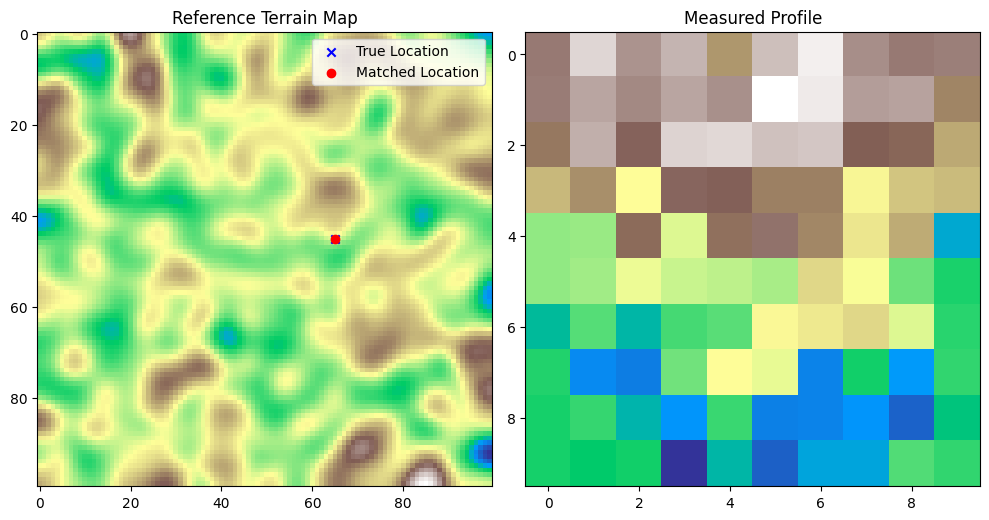

In [6]:
# Visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Reference Terrain Map")
plt.imshow(terrain_map, cmap='terrain')
plt.scatter(measured_y + 5, measured_x + 5, marker='x', color='blue', label='True Location')
plt.scatter(matched_coords[1] + 5, matched_coords[0] + 5, marker='o', color='red', label='Matched Location')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Measured Profile")
plt.imshow(measured_profile, cmap='terrain')

plt.tight_layout()
plt.show()


## 测试轨迹匹配

### 用法一: 假定航向不变

In [98]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.01, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=1)

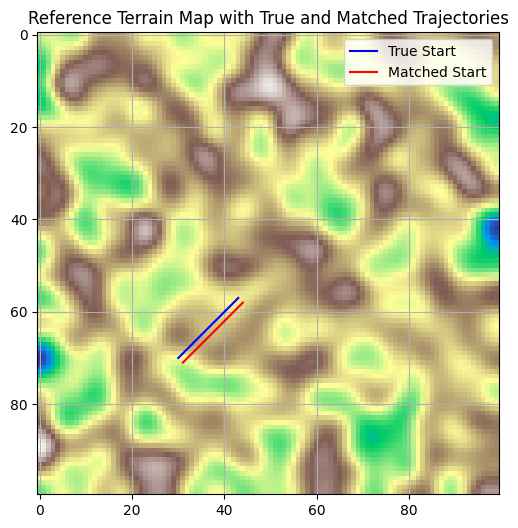

In [69]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")


In [66]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.extract_trajectory_patch(true_start_x, true_start_y, true_heading)

# 用法二:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.005, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

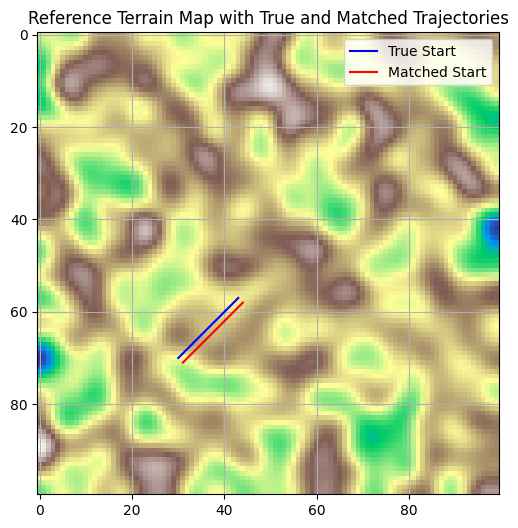

In [67]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")


### 用法二：航向不断变换

In [96]:
# Simulate terrain map and trajectory-based profile
np.random.seed(42)
terrain_map = gaussian_filter(np.random.rand(100, 100), sigma=3)
true_start_x, true_start_y = 30, 70
true_heading = 45
trajectory_length = 20

matcher_traj = TrajectoryBasedTerrainMatcher(reference_map=terrain_map, window_length=trajectory_length)
true_profile = matcher_traj.gen_multi_trajectory_patch(true_start_x, true_start_y, true_heading, mode=2)

# 用法三:
measured_profile = deepcopy(true_profile)
measured_profile[2, :] = measured_profile[2, :] + np.random.normal(0, 0.01, measured_profile.shape[1])
estimated_coords = matcher_traj.match_trajectory(measured_profile, true_heading, gen_mode=2)

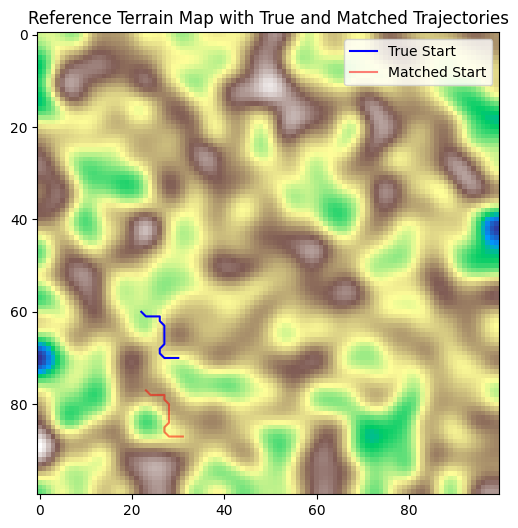

In [97]:
# Visualization
plt.figure(figsize=(6, 6))
plt.title("Reference Terrain Map with True and Matched Trajectories")
plt.imshow(terrain_map, cmap='terrain')
plt.plot(true_profile[0, :], true_profile[1, :], color='blue', label='True Start')
plt.plot(estimated_coords[0, :], estimated_coords[1, :], color='red', label='Matched Start', alpha=0.5)
plt.legend()
#plt.grid(True)
plt.show()

# Evaluation
# rmse_traj = compute_rmse((true_start_x, true_start_y), estimated_coords)
# print(f"Trajectory Matching RMSE: {rmse_traj:.2f} pixels")